In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras

# Convolutional Layers
These are 2D layers of an ANN which take in inputs from a small subset of the preceding layer, as opposed to a feedforward network which takes in all outputs from the preceding layer. This architecture is inspired by the brain's usage of receptive fields for extracting higher and higher detailed features from the visual field. Thus, the first convolutional layer works by, for each node, taking in, say, a square-sized grid of input from the input layer. Then, the next node takes in a grid that overlaps with the first grid but is not equal--the amount of overlap is determined by the **stride** of the convolutional layer receiving input, which is a 2 parameter function which determines how far the receptive-field (the set of output from the preceding layer fed into the convolutional layer) moves up/down and back/forward as we move to the next neuron in the convolutional layer. Higher sweep values entails lower computational complexity. You can visualize a stack of convolutional layers and their receptive fields as pyramids from each layer being projected onto the lower layer.

## Filters aka Convolution Kernels:
For each layer of the CNN, the weights of the neurons comprising a layer determine which features get propagated forward in the network from that layer. We therefore call such layers *filters* or *convolutional kernels* (I think kernels because coarse-graining happens when filtering occurs, and so objects are sent to the kernel, similar to abstract algebra). For example, if we have a layer with a vertical strip of neurons set to 1 and the rest of the layer's neurons weight's set to zero, then this layer would only be capable of doiing a good job capturing the vertical features of the image. However, CNNs learn the filters through training, and so they are not a hyperparameter that we have to tune. Also, we call the output of a filter a *feature map*.

### Stacking feature maps:
Actually, convolutional layers are three dimensional, in that we have multiple filters per each layer. That is, each layer of a CNN is composed of multiple filters which each produce different feature maps, and then these feature maps are stacked for extraction by the next convolutional layer. The filters are different by virtue of having different parameters (i.e., weights and bias terms); however, what the filters of a layer have in common is that they receive input from the same receptive field. So, each layer is actually a stack of filters, and therefore multiple features can be extracted from each layer of the CNN.

# Tensorflow Implementation

In [1]:
from sklearn.datasets import load_sample_image

In [4]:
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

In [7]:
batch_size, height, width, channels = images.shape

In [8]:
# Create 2 filters
filters = np.zeros(shape=(7,7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

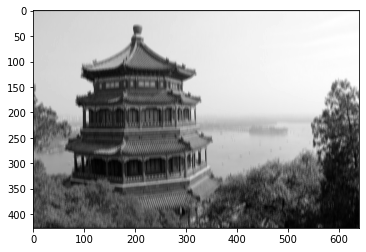

In [22]:
plt.imshow(outputs[0, :, :, 1], cmap="gray")

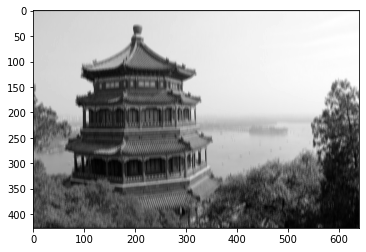

In [23]:
plt.imshow(outputs[0, :, :, 0], cmap="gray")

The above two images are the output of the two filters we made and then applied to the convolutional neural network function. So, the first image is (I think) of the vertical filter and the second is of the horizontal filter.

Notice that "channels" are for the different colors in the image, and hence filters are 4D tensors, since each filter has a different dimension for handling each channel.

However, we would not, in practice, hand craft our own filters. Thus, we use keras to implement trainable layers:

In [26]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, 
                           strides=1, padding="SAME", activation="relu")
# Notice that the kernel_size of 3 specifies that the receptive fields
# will be 3x3 grids

###  Memory requirements of CNN
The CNN architecture requires a lot of RAM. This is because of the filters and backpropagation needing to save the outputs from the forward pass so that partial derivatives can be computed on the back pass. So, it is possible that you will run out of RAM training a CNN if you have a large batch size.

# Pooling Layers

These are layers that coarse-grain the output of previous layers, which yields a form of regularization since information is destroyed. This also leads to equivalence classes of outputs from layer n-1 and layer n where layer n is the pooling layer and n-1 is the convolutional layer, since some outputs of layer n-1, despite being different, map to the same output from layer n. Thus, this yields some invariance in the outputs from the pooling layer, in that, say if we are doing a classification task, slight rotations in features of the image will not cause the neural network to classify the picture differently, since it cannot perceive those rotations by virtue of the pooling layers handling them invariantly. So, if we have a task for a neural net wherein we do not want invariance--but rather equivariance--then we may not want to use pooling layers. Further, they also have a stride and a receptive field.

# CNN Architectures:
The canonical CNN architecture begins with convolutional layers, which coarse-grain the image via their receptive fields and filters, which is followed by pooling layers for more coarse-graining. Typically, this first convolutional layer has a 3x3 stride, but sometimes 5x5 is good; bigger stride entails greater computational efficiency, but causes more information to be lost. Then, we typically have another stack of convolutional layers agian followed by pooling layers. Finally, we have fully connected layers. If we are doing a classification task, then the output is usually done via a softmax layer. Also, between the convolutional layers, there typically is a relu layer.

In [3]:
# Here is a cnn architecture that can handle Fashion mnist:
model = keras.models.Sequential([keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=[28,28,1]),
                                keras.layers.MaxPooling2D(2),
                                keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
                                keras.layers.MaxPooling2D(2),
                                keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
                                keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
                                keras.layers.MaxPooling2D(2),
                                keras.layers.Flatten(),
                                keras.layers.Dense(128, activation="relu"),
                                keras.layers.Dropout(0.5),
                                keras.layers.Dense(64, activation="relu"),
                                keras.layers.Dropout(0.5),
                                keras.layers.Dense(10, activation="softmax")])

So, this model begins with an input convolutional layer that has 64 filters and a 7x7 receptive field; the default stride is 1x1. We make the input_shape 28x28x1 because the images are 28x28 and there is only one color channel, namely grayscale, as opposed to RGB, wherein we'd have 28x28x3. We then do a pooling layer that has a 2x2 receptive field and so cuts the image in half since the default stride is 1x1. Thus, on the next layer, we do a smaller receptive field and we have twice as many filters--since we can combine the features extrated from the first convolutional layer into more complex features, hence more filters. Then, we continue this theme by expanding to 256 filters on the next convolutional layers. Next, we finish off by a pretty standard MLP that shrinks toward the output and has dropout layers for regularization (so, neurons have a 50% chance of being activated in those layers).

AlexNet is the CNN that set off the deep learning revolution, made by Hinton et al. One of its features is local response normalization; neurons of in a filter of a convolutional layer that have heavy weights inhibit neurons in other filters in the same column, which stops neurons in the other filters from learning the same feature that the neuron in this filter is learning, which enables broader mapping of the feature space presented by the images, since now the filters do not just learn the same features.

GoogleNet by Christian Szegedy managed to get an error rate of 7% on MNIST in 2014, an improvement over AlexNet. GoogleNet is superior primarily by leveraging more compute--the number of layers is more than double Alex. However, AlexNet has 6*/10^7 parameters whereas GoogeNet has only 6*/10^6 parameters. This is because GoogleNet has so-called *inception modules* which are like "convolutional layers on steroids" according to Aurelion. They work by consiting of two layers wherein each layer has sub-layers--the first layer is composed of CNNs of various receptive field sizes and the second layer does the same. However, in the second layer, we have two convolutional layers with a receptive field size of 1. What this does is enable the inception modules to learn features concerning the depth of the image.

#### ResNet (Residual Network)
is a neural network model that achieved the lowest error rate for MNIST in 2015. It works primarily by being very deep--with 152 layers. Training the network is made more efficient because of the **residual units**, hence the name ResNet. These residual units are simply a subset of layers, say 2, that plugs their input into a skip connection that terminates in the output layer, and so the input signal can be propagated throughout the entire network before previous layers are trained. Further, since the input gets to skip the training layers, and eventually makes its way to the output layer where the model is evaluated, the cost function takes the raw input as part of its cost function, and so this forces the model to learn the function h(x) - x rather than just h(x). So, we are learning the identity function, since the goal is to minimize the error generated by h(x), and so h(x) - x ~= 0 ==> h(x) ~= x. This is useful if, as in many classification tasks, the function we want to learn is close to the identity function.

#### Squeeze-Excitation Net (SENet)

The SENet works by using inception modules and residual units but introduces a new architectural feature, name Squeeze-Excitation units (SEs). SEs are very simple, consisting only of 3 layers; they are akin to modulatory connections in the nervous system, namely axo-axonic connections. So, 

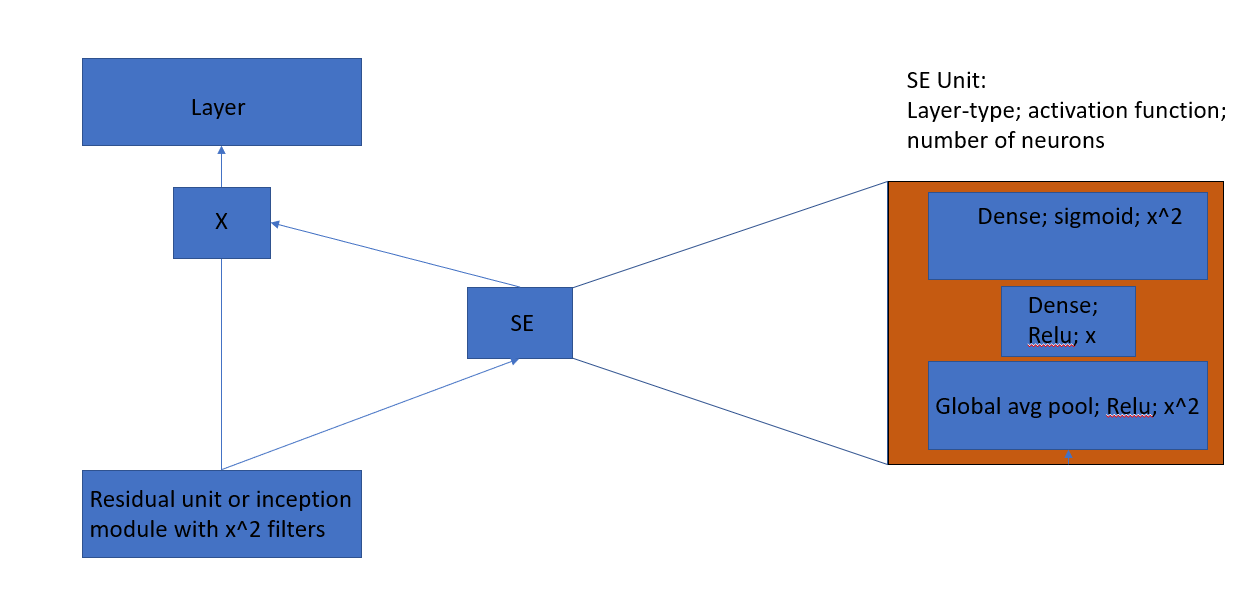

the SE unit works by taking the global avg pool of each filter from the previous layer; so if the previous layer had 256 filters, then this global avg pool layer has 256 inputs. Then, a big squeeze happens, where we reduce that input size down to about its square root. This forces the SE unit to learn lower dimensional representations/embeddings of the features, which is a form of coarse-graining that causes the network to generalize better, since now the map: data --> classes has a kernel by virtue of this coarse-graining, and so now multiple patterns in the data can map to the same output (say, classification). So, after the squeeze, we go back to the size of the input to the SE unit, and then the sigmoid activation function is used so that we output values between 0 and 1, wherein those values then multiply the respective outputs from the layer preceding the SE unit--so, outputs from the SE unit that are close to 1 mean that the respective filter from the previous layer is hardly altered whereas outputs near zero from the SE unit cause the respective filters to vanish; this can be understood as implementing the kernel/null-space strategy mentioned above in this paragraph.